<a href="https://colab.research.google.com/github/samurai-kai/ME570/blob/main/13_Multi_Output_Behavior_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nvidia Pilotnet

In [ ]:
import json
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import wandb
import cv2
import tensorflow as tf
from scipy.signal import medfilt

In [ ]:
# Connect to Google Drive
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Update 'base_dir' with the path to your private workspace on Google Drive
base_dir = '/content/drive/MyDrive/00_CalPoly/00_Workspace'

if not os.path.exists(base_dir):
  raise FileNotFoundError(f'Base directory {base_dir} does not exist')

Mounted at /content/drive


## Utils

In [ ]:
# Weighting the straights 5× higher did not lead to good results in practice,
# possibly because the model still saw too many curves during training.

# Simply reducing the number of curves (i.e. using a balanced dataset)
# worked better by forcing the model to learn from both classes equally.

# Define weighted sparse categorical crossentropy
def weighted_sparse_categorical_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        weights = tf.gather(class_weights, y_true)

        ce = tf.keras.backend.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
        return tf.multiply(ce, weights)  # Element-wise multiply

    return loss_fn

In [ ]:
def median_filter(data, kernel_size=5):
    return medfilt(data, kernel_size=kernel_size)

def preprocess_images(im_selected, ymin=120, ymax=265):
    """
    Preprocess a list of RGB images for input into a TensorFlow model.

    Steps:
    - Crop the vertical range of each image from ymin to ymax (e.g., remove sky and hood).
    - Convert the cropped image to grayscale.
    - Normalize pixel values to the range [0, 1].
    - Add a channel dimension to match TensorFlow's expected input shape.

    Args:
        im_selected (List[np.ndarray]): List of RGB images as NumPy arrays (H, W, 3).
        ymin (int): Starting row index for cropping.
        ymax (int): Ending row index for cropping.

    Returns:
        np.ndarray: Array of shape (N, ymax - ymin, W, 1) with float32 grayscale images.
    """
    processed = []
    for img in im_selected:
        # Crop image vertically to remove irrelevant areas (e.g., sky, car hood)
        img_cropped = img[ymin:ymax]

        # Convert the cropped image to grayscale (1 channel)
        gray = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2GRAY)

        # Normalize pixel values to the range [0, 1]
        norm = gray.astype(np.float32) / 255.0

        # Add channel dimension to match model input shape (H, W, 1)
        processed.append(np.expand_dims(norm, axis=-1))

    # Return a NumPy array of shape (N, H, W, 1)
    return np.array(processed, dtype=np.float32)


def filter_min_distance(idx, min_distance=10):
    # Given a list of indices, return a subset where each index is at least
    # `min_distance` apart from the previous one.
    #
    # Example:
    #   idx = [1, 2, 3, 4, 5, 15]
    #   filter_min_distance(idx, min_distance=10) -> [1, 15]
    #
    # Explanation:
    #   - Start with 1
    #   - Skip 2–5 because they're too close to 1
    #   - 15 is far enough from 1 (15 - 1 = 14 >= 10), so it's added

    # Convert input to sorted NumPy array
    idx = np.sort(np.array(idx))
    selected = []

    for i in idx:
        # Add the index if this is the first one,
        # or if it's at least `min_distance` away from the last selected
        if not selected or i - selected[-1] >= min_distance:
            selected.append(i)

    # Return the filtered indices as a NumPy array
    return np.array(selected)


def sample_balanced_with_flipping(y, images, bins=9, min_distance=10):
    """
    Augments data by flipping, balances bins, and filters for minimum spacing.

    Parameters:
    - y: 1D numpy array of steering angles
    - images: numpy array of shape (N, H, W, C)
    - bins: number of histogram bins
    - min_distance: minimum index spacing in each bin

    Returns:
    - y_selected: filtered and balanced steering angles
    - im_selected: corresponding selected images
    """
    y = np.array(y)
    images = np.array(images)

    # Flip images and angles
    images_flipped = np.flip(images, axis=2)
    y_flipped = -y

    # Concatenate originals and flipped
    y_combined = np.concatenate([-y, y])
    images_combined = np.concatenate([images_flipped, images], axis=0)

    # Bin edges
    _, edges = np.histogram(y_combined, bins=bins)

    # Filtered bin-wise indices
    filtered_bins = []
    for i in range(len(edges) - 1):
        idx = np.where((y_combined >= edges[i]) & (y_combined < edges[i+1]))[0]
        filtered = filter_min_distance(idx, min_distance)
        filtered_bins.append(filtered)

    # Global N: minimum filtered size per bin
    N = min(len(b) for b in filtered_bins if len(b) > 0)

    # Select up to N indices per bin
    selected_indices = []
    for idx in filtered_bins:
        if len(idx) == 0:
            continue
        sel = np.linspace(0, len(idx) - 1, min(N, len(idx)), dtype=int)
        selected_indices.extend(idx[sel])

    selected_indices = np.array(selected_indices)

    # Final selection
    y_selected = y_combined[selected_indices]
    im_selected = images_combined[selected_indices]

    return y_selected, im_selected, selected_indices


## Load Data

In [ ]:
# Connect to Foxglove
!pip install -qq git+https://github.com/william-mx/foxglove-bag-reader.git
from foxglove_bag_reader import BagfileReader

API_KEY = "fox_sk_j4qRQHhh0cd8mgMAQzDXNPwhGEfkLOXe"
r = BagfileReader(API_KEY)
r.print_recordings()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.6 MB/s eta 0:00:00
Available Recordings:

bshaped_track_all                        → 2y57fL95RUnUG5MW
bshaped_track_depth                      → rec_0dY0zYREG8TYFbTY
bshaped_track_following_left             → rec_0dX26NC9WkjKqTyi
bshaped_track_following_right            → rec_0dX27U8jsoFpbA2u
bshaped_track_odometry                   → rec_0dY0ylXuthVmxy44
circle_drive_fixed_speed_left            → rec_0dWf0XUVbrIrRtgL
cones_lidar_slam                         → rec_0dY0z7WHao9tYAZY
hallway_lidar_slam                       → rec_0dY106wizvoNRenI
imu_speed_stairs                         → rec_0dWf0csWqOJcTgWT
imu_static                               → rec_0dWf1wPygPWHB8ne
ir_lidar_calibration                     → rec_0dY10RmyGbqo3RYh
lid

In [ ]:
# List of bagfile names to process
names = ['bc_acc_right', 'bc_acc_left', 'bc_right', 'bc_left',
         'bc_right_vol_II', 'bc_left_vol_II',
         'bc_right_vol_III', 'bc_left_vol_III']

y_angles = []     # List to store steering angles from all files
all_images = []   # List to store preprocessed images from all files
y_speed = []      # List to store speed values from all files

for name in names:
    print(f"Parsing: {name}")

    # Open the specific bagfile recording by name
    r.get_recording_by_name(name)

    # Load steering command messages (AckermannDrive) and camera frames into DataFrames
    df_ackermann = r.parse_topic('/rc/ackermann_cmd')
    df_camera = r.parse_topic('/camera/camera/color/image_raw')

    # Synchronize image and steering angle data based on timestamps
    df_synced = r.sync_dataframes(df_camera, ack=df_ackermann)

    # Extract the ground truth steering angles
    y = df_synced['steering_angle_ack'].values
    y_filtered = median_filter(y, kernel_size = 9)

    # Load driving events that were manually defined in Foxglove (e.g. for labeling segments)
    events = r.get_events()

    # Match each event to the corresponding image indices in the synced DataFrame
    events = r.find_indices_within_events(df_camera, events)

    # Speed levels
    speed_indices = np.zeros_like(y, np.uint8)

    for event in events:

        if event['metadata'].get('segment') == 'straight':

          idx = np.array(event['indices'])  # Get indices for this event

          speed_indices[idx] = 1


    # Since the dataset is augmented by flipping all images,
    # we also need to duplicate the speed labels to match the new data
    speed_indices = np.concatenate([speed_indices, speed_indices])

    # Extract all raw RGB images from the camera topic
    images = r.get_all_images("/camera/camera/color/image_raw")

    # Balance the dataset and augment it by flipping images and angles
    # This helps the model generalize better and reduces steering bias
    y_selected, im_selected, selected_indices = sample_balanced_with_flipping(y_filtered, images)

    # Select the corresponding speed labels for the sampled training indices
    speed_selected = speed_indices[selected_indices]

    # Convert selected angles to float32 for training
    y_train_ = y_selected.astype(np.float32)  # Shape: (N,)

    # Preprocess selected images: crop, grayscale, normalize, add channel dim
    x_train_ = preprocess_images(im_selected)  # Shape: (N, H, W, 1)

    # Append processed data to overall dataset
    y_angles.append(y_train_)
    all_images.append(x_train_)
    y_speed.append(speed_selected)

# Concatenate all steering angles and images from different recordings
y_angles = np.concatenate(y_angles)             # Shape: (Total N,)
y_speed = np.concatenate(y_speed)               # Shape: (Total N,)
all_images = np.concatenate(all_images, axis=0) # Shape: (Total N, H, W, 1)

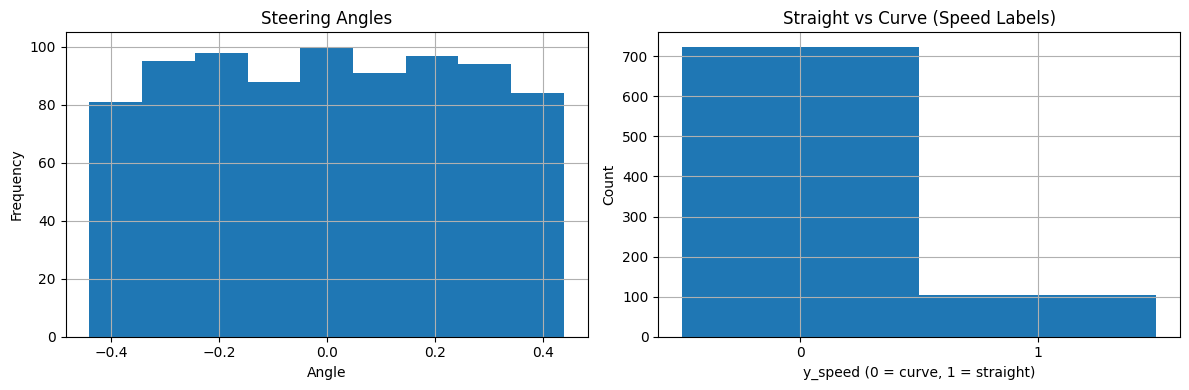

In [ ]:
# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of steering angles
axes[0].hist(y_angles, bins=9)
axes[0].set_title("Steering Angles")
axes[0].set_xlabel("Angle")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

# Histogram of speed labels (0 = curve, 1 = straight)
axes[1].hist(y_speed, bins=[-0.5, 0.5, 1.5])  # Bin edges centered on 0 and 1
axes[1].set_title("Straight vs Curve (Speed Labels)")
axes[1].set_xlabel("y_speed (0 = curve, 1 = straight)")
axes[1].set_ylabel("Count")
axes[1].set_xticks([0, 1])  # Set x-axis ticks to integer labels
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
filepath = base_dir + '/data/pilot_dataset_speed.npz'

# save dataset
# np.savez_compressed(filepath, X=all_images, y_angles=y_angles, y_speed=y_speed)

In [ ]:
filepath = base_dir + '/data/pilot_dataset_speed.npz'

# Load data
data = np.load(filepath)
x_all = data["X"]
y_angles_all = data["y_angles"]
y_speed_all = data["y_speed"]

# Get indices for straights and curves
idx_straight = np.where(y_speed_all == 1)[0]
idx_curve = np.where(y_speed_all == 0)[0]

# Define size of straight samples and curves per dataset
n_samples = min(len(idx_straight), len(idx_curve) // 3)

# Randomly sample a fixed straight set
np.random.seed(42)
idx_straight_sampled = np.random.choice(idx_straight, n_samples, replace=False)

# Randomly shuffle curve indices and split into 3 non-overlapping sets
idx_curve_shuffled = np.random.permutation(idx_curve)
idx_curve_1 = idx_curve_shuffled[0:n_samples]
idx_curve_2 = idx_curve_shuffled[n_samples:2*n_samples]
idx_curve_3 = idx_curve_shuffled[2*n_samples:3*n_samples]

# Create 3 balanced datasets
sets = []
for idx_curve_set in [idx_curve_1, idx_curve_2, idx_curve_3]:
    idx_combined = np.concatenate([idx_straight_sampled, idx_curve_set])
    np.random.shuffle(idx_combined)

    x = x_all[idx_combined]
    y_angle = y_angles_all[idx_combined]
    y_speed = y_speed_all[idx_combined]

    sets.append((x, y_angle, y_speed))

# Unpack them if needed
x_train_1, y_angle_1, y_speed_1 = sets[0]
x_train_2, y_angle_2, y_speed_2 = sets[1]
x_train_3, y_angle_3, y_speed_3 = sets[2]


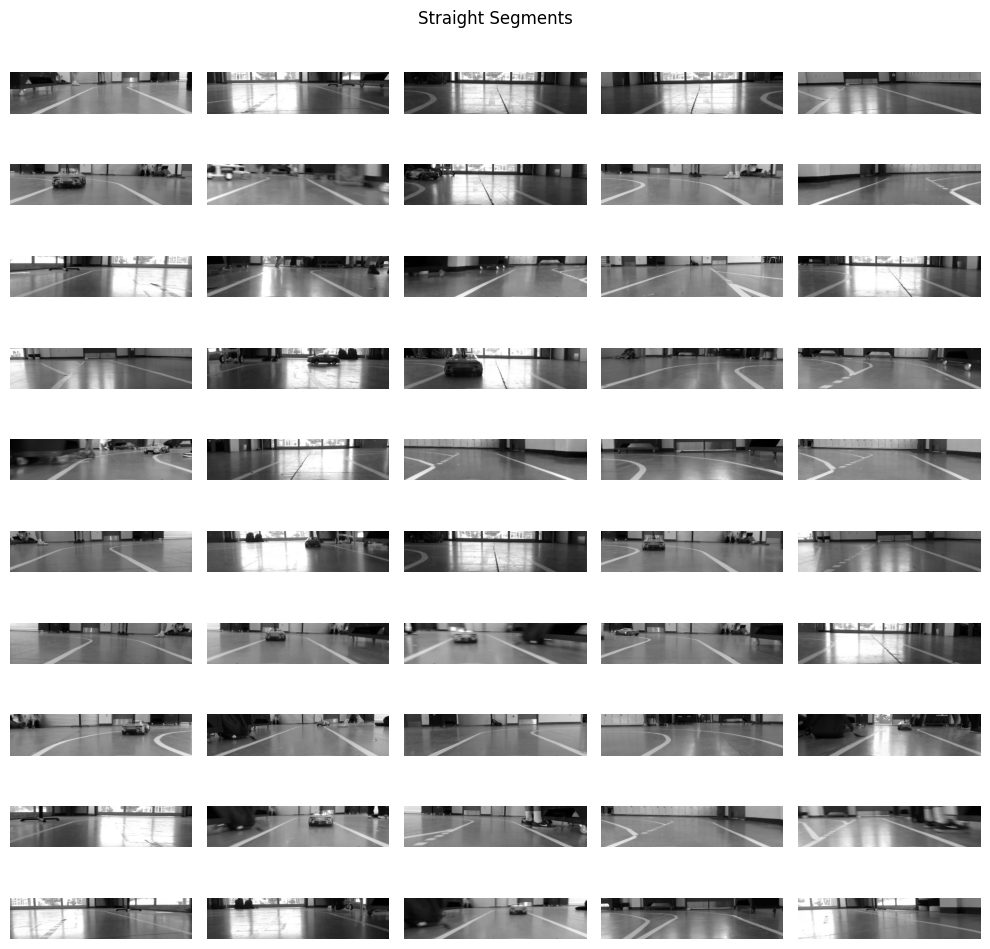

In [ ]:
# Get indices of straight segments
straight_indices = np.where(y_speed_1 == 1)[0]

# Randomly choose 50 straight samples
selected = np.random.choice(straight_indices, size=50, replace=False)

# Plot 10x5 grid
fig, axes = plt.subplots(10, 5, figsize=(10, 10))
for ax, idx in zip(axes.flat, selected):
    ax.imshow(x_train_1[idx], cmap='gray')
    ax.axis('off')

plt.suptitle("Straight Segments")
plt.tight_layout()
plt.show()


## 🧠 Curriculum Learning for Imbalanced Datasets

In [ ]:
from wandb.integration.keras  import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [ ]:
VAL_SPLIT = 0.2
BATCH_SIZE = 8

# List to store train/val datasets
train_datasets = []
val_datasets = []

# Loop over your 3 sets: (x_train_1, y_angle_1, y_speed_1), etc.
for x, y_angle, y_speed in sets:

    # Shuffle
    indices = np.random.permutation(len(x))
    x_shuffled = x[indices]
    y_angles_shuffled = y_angle[indices].astype(np.float32)
    y_speed_shuffled = y_speed[indices].astype(np.int32)

    # Split into train/val
    val_size = int(VAL_SPLIT * len(x))
    x_val = x_shuffled[:val_size]
    y_val_steer = y_angles_shuffled[:val_size]
    y_val_speed = y_speed_shuffled[:val_size]

    x_train = x_shuffled[val_size:]
    y_train_steer = y_angles_shuffled[val_size:]
    y_train_speed = y_speed_shuffled[val_size:]

    # Build tf.data.Dataset objects
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, {'steering_angle': y_train_steer, 'speed': y_train_speed})
    ).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (x_val, {'steering_angle': y_val_steer, 'speed': y_val_speed})
    ).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Store them
    train_datasets.append(train_ds)
    val_datasets.append(val_ds)

# After the loop: unpack the datasets
train_ds_1, train_ds_2, train_ds_3 = train_datasets
val_ds_1, val_ds_2, val_ds_3 = val_datasets

In [ ]:
LR = 1e-2 # learning rate
EPOCHS = 30

run = 'classic-pine-17'
checkpoint_dir = base_dir + '/models'
checkpoint_path = checkpoint_dir + f'/{run}/best_pilotnet.keras'

# Load the pre-trained model
model = tf.keras.models.load_model(checkpoint_path)

# Define callbacks
ckpt_path = checkpoint_dir + "/speed_pilotnet.keras"

checkpoint_cb = ModelCheckpoint(
    ckpt_path,
    monitor="val_speed_loss",
    save_best_only=True,
    save_weights_only=False, # Saves full model, not just weights
    verbose=1
)

# Freeze all layers (we only want to train the new output)
for layer in model.layers:
    layer.trainable = False

# Get the second-last layer before the original regression output
x = model.layers[-2].output

# Re-add the original regression output
steering_output = model.layers[-1](x)

# Add a new classification head for speed prediction
n_classes = 2  # e.g., 0 = curve, 1 = straight
speed_output = Dense(n_classes, activation='softmax', name='speed')(x)

# Define a new model with two outputs
multi_model = Model(inputs=model.input, outputs=[steering_output, speed_output])

# Compile to only train the classification head
multi_model.compile(
    loss={'steering_angle': 'mae', 'speed': 'sparse_categorical_crossentropy'},
    loss_weights={'steering_angle': 0.0, 'speed': 1.0},  # Don't train steering, only speed
    optimizer=tf.keras.optimizers.Adam(LR),
    metrics={'speed': 'accuracy'}
)

# multi_model.summary(show_trainable=True)

In [ ]:
# Fit the model
multi_model.fit(
    train_ds_1,
    validation_data=val_ds_1,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb]
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.6950 - speed_accuracy: 0.4508 - speed_loss: 0.6950 - steering_angle_loss: 0.0828
Epoch 1: val_speed_loss improved from inf to 0.67213, saving model to /content/drive/MyDrive/00_CalPoly/00_Workspace/models/speed_pilotnet.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.6946 - speed_accuracy: 0.4512 - speed_loss: 0.6946 - steering_angle_loss: 0.0829 - val_loss: 0.6750 - val_speed_accuracy: 0.4333 - val_speed_loss: 0.6721 - val_steering_angle_loss: 0.0377
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.6738 - speed_accuracy: 0.5551 - speed_loss: 0.6738 - steering_angle_loss: 0.0845
Epoch 2: val_speed_loss improved from 0.67213 to 0.65498, saving model to /content/drive/MyDrive/00_CalPoly/00_Workspace/models/speed_pilotnet.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.6738 - speed_accuracy: 0.5537 - speed_loss: 0.6738 - steering_angle_loss: 0.0847 - val_loss: 0.6579 - val_speed_accuracy: 0.4500 -

In [ ]:
LR = 1e-3
EPOCHS = 10

for train_ds, val_ds in zip(train_datasets, val_datasets):

    # Reload model to start fresh for each run
    model = tf.keras.models.load_model(ckpt_path)

    # Freeze all layers first
    for layer in model.layers:
        layer.trainable = False

    # Unfreeze last 10 layers for fine-tuning
    for layer in model.layers[-10:]:
        layer.trainable = True

    # Compile
    model.compile(
        loss={'steering_angle': 'mae', 'speed': 'sparse_categorical_crossentropy'},
        loss_weights={'steering_angle': 1.0, 'speed': 1.0},
        optimizer=tf.keras.optimizers.Adam(LR),
        metrics={'speed': 'accuracy'}
    )


    # Train
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_cb]
    )


## Evaluate

In [ ]:
# Open the specific bagfile recording by name
r.get_recording_by_id('rec_0dfpgF8tWwMN6zHd')

# Load steering command messages (AckermannDrive) and camera frames into DataFrames
df_ackermann = r.parse_topic('/rc/ackermann_cmd')
df_camera = r.parse_topic('/camera/camera/color/image_raw')

# Synchronize image and steering angle data based on timestamps
df_synced = r.sync_dataframes(df_camera, ack=df_ackermann)

# Extract the ground truth steering angles
y = df_synced['steering_angle_ack'].values
y_filtered = median_filter(y, kernel_size = 9)

# Load driving events that were manually defined in Foxglove (e.g. for labeling segments)
events = r.get_events()

# Match each event to the corresponding image indices in the synced DataFrame
events = r.find_indices_within_events(df_camera, events)

# Speed levels
y_speed = np.zeros_like(y, np.uint8)

for event in events:
    idx = np.array(event['indices'])  # Get indices for this event

    y_speed[idx] = 1

# Extract all raw RGB images from the camera topic
images = r.get_all_images("/camera/camera/color/image_raw")


# Convert selected angles to float32 for training
y_angles = y_filtered.astype(np.float32)  # Shape: (N,)

# Preprocess selected images: crop, grayscale, normalize, add channel dim
all_images = preprocess_images(images)  # Shape: (N, H, W, 1)

# save dataset
# filepath = base_dir + '/data/pilot_testset_speed.npz'
# np.savez_compressed(filepath, X=all_images, y_angles=y_angles, y_speed=y_speed)

In [ ]:
# 1. Load test data
filepath = base_dir + '/data/pilot_testset_speed.npz'

# Load test data
data = np.load(filepath)
x_test = data["X"]
gt_angles = data["y_angles"]
gt_speed = data["y_speed"]

In [ ]:
# 0. Load the trained model
multi_model = tf.keras.models.load_model(ckpt_path)

In [ ]:
predictions = multi_model.predict(x_test)

pred_angles, pred_speed = predictions # (N,1), (N,2)
speed_indices = np.argmax(pred_speed, axis =1) # (N,)
speed_indices = median_filter(speed_indices, 15) # filter data

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step


In [ ]:
# 2. Combine labels if your model has multiple outputs
# Example for a model with two outputs: [angle_output, speed_output]
y_test = [gt_angles, gt_speed]

# 3. Evaluate the model
loss, steering_mae, speed_loss, speed_acc = multi_model.evaluate(x_test, y_test)

print("Steering MAE:", steering_mae)
print("Speed Accuracy:", speed_acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 611ms/step - loss: 0.4953 - speed_accuracy: 0.8448 - speed_loss: 0.4409 - steering_angle_loss: 0.0537
Steering MAE: 0.0722331628203392
Speed Accuracy: 0.8517110347747803


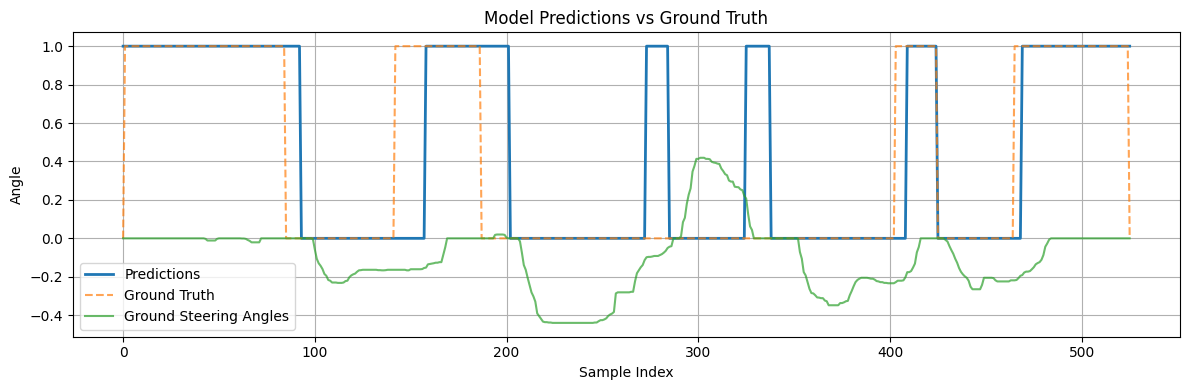

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(speed_indices, label="Predictions", linewidth=2)
plt.plot(gt_speed, label="Ground Truth", linestyle='--', alpha=0.7)
plt.plot(gt_angles, label="Ground Steering Angles", alpha=0.7)
plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Angle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()